# Monet Image Generation Kaggle Competition

The goal of this competition is to create a GAN that generates Monet-style images from photographs. A GAN consists of a generator model and a discriminator that work against each other. The generator is trying to create images that fool the discriminator which is working to correctly distinguish between actual and artificial Monet images. 

The Kaggle competition is available here: https://www.kaggle.com/competitions/gan-getting-started/overview

As a submission, the notebook will turn each of the provided photos to Monet style and be judged on a metric called Memorization-informed Frechet Inception Distance (MiFID). The lower the score the better. MiFID has become a standard evaluation metric for image generation tasks.

Code available in github: https://github.com/blockee/cu-deep/tree/main/monet

### Environment Setup and Intro

The code in the first part of this notebook comes from the tutorial notebook available here: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

I've added my own comments and explanations as markdown throughout this first part in order to document my understanding of the process. In the latter half of the notebook, I alter both the generator and discriminator to try to improve the performance of the network. The updated models, explanations of the changes, results, and discussion are all additions above and beyond what was available in the tutorial notebook. 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

### Image Exploration and Dataset Description

From the competition description, we know there are 300 Monet files and approximately 7,000 photos. All images are 256x256 and include three color channels. 

In [ ]:
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))
IMAGE_SIZE = [256, 256]

IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

The images themselves are the only relevant data - we know their class (Monet or photo) based on the file directory. The code below loads the dataset and allows us to preview a photo and a Monet. 

In [ ]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [ ]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

### Generator Build

The tutorial architecture uses a UNET architecture. UNET combines an encoding and decoding path. The network is effective at identifying local and global features. The downsample portions reduce the dimensions while upsample does the opposite.

More information about UNET architecture available here: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

https://www.analyticsvidhya.com/blog/2023/08/unet-architecture-mastering-image-segmentation/

In [ ]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.1)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.1)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.1)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.1)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

The function below creates the generator which downsample the image first and then upsamples afterwards. During the process that repeatedly downsamples, the code also established skip connections. Skip connections propogate information from early in the network to later layers.

More info here: https://forums.fast.ai/t/what-is-the-role-of-skip-connections-in-u-net/100727

https://arxiv.org/abs/2402.08276

In [ ]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.1)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### Original Discriminator

The discriminator is tasked with distinguishing between real Monet images and artifically-generated ones.

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    
    norm1 = layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init)(conv)
   
    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [ ]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

### CycleGAN Model Build

We will subclass a tf.keras.Model so that we can run fit() later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Loss Function Definition

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

### Training the CycleGAN

In [ ]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=12
)

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Outputting the Necessary Files

In [ ]:
import PIL
! mkdir ../output_images

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../output_images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/output_images")

### Alternative Model Architectures - Novel Code additions and Personal Results Begin Here

Below, I added altered versions of both the generator and the discriminator. I will discuss the changes and improvements in each section. I resubmitted the notebook with several different configurations of these altered networks and present the results of those submissions below.

I added the following to the generator in an effort to improve performance.

1. Residual Connections - seen in the res_block
2. Self Attention
3. Dropout during Upsampling

Residual connections are an enhancement to the skip connections. They add convolution and normalization to those skip connections. Additional information here: https://deepai.org/machine-learning-glossary-and-terms/residual-connections

Self attention is a mechanism that allows the network to learn about how pixels relate to the image as a whole rather than just how pixels relate to other local pixels. It uses queries, weights, and keys to mix and weigh the information from all parts of the image. Self attention helps makes textures more consistent. That benefit is especially relevant given that we want a Monet-like texture added to our photos. More info: https://h2o.ai/wiki/self-attention/

I also added dropout during the upsampling portion in order to help prevent overfitting which is always a potential issue.

In [ ]:
# More sophisticated generator

OUTPUT_CHANNELS = 3

def res_block(x, filters, kernel_size=3, strides=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = layers.GroupNormalization(groups=8)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.GroupNormalization(groups=8)(x)
    x = layers.add([shortcut, x])
    x = layers.ReLU()(x)
    return x

def self_attention(x, filters):
    f = layers.Conv2D(filters // 8, 1)(x)
    g = layers.Conv2D(filters // 8, 1)(x)
    h = layers.Conv2D(filters, 1)(x)
    
    s = tf.matmul(tf.reshape(f, [tf.shape(f)[0], -1, tf.shape(f)[-1]]),
                  tf.reshape(g, [tf.shape(g)[0], -1, tf.shape(g)[-1]]),
                  transpose_b=True)
    beta = tf.nn.softmax(s, axis=-1)
    
    o = tf.matmul(beta, tf.reshape(h, [tf.shape(h)[0], -1, tf.shape(h)[-1]]))
    o = tf.reshape(o, tf.shape(x))
    x = layers.add([x, o])
    return x

def downsample(filters, size, apply_attn=False, apply_instancenorm=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    #gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.1)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    result.add(layers.GroupNormalization(groups=8))
    result.add(layers.LeakyReLU())
    result.add(layers.Conv2D(filters, 3, padding='same'))
    result.add(layers.GroupNormalization(groups=8))

    # if apply_instancenorm:
    #     result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))
        
    if apply_attn:
        result.add(layers.Lambda(lambda x: self_attention(x, filters)))
    return result

def upsample(filters, size, apply_dropout=False, apply_attn=False):
    initializer = tf.random_normal_initializer(0., 0.02)
   # gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.1)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(layers.GroupNormalization(groups=8))
    result.add(layers.ReLU())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    if apply_attn:
        result.add(layers.Lambda(lambda x: self_attention(x, filters)))
    return result

def Generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4),
        downsample(128, 4),
        downsample(256, 4, apply_attn=True),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4, apply_attn=True),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True, apply_attn=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  activation='tanh')

    x = inputs
    skips = []

    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
        x = res_block(x, x.shape[-1])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

I made the following changes to the discriminator.

1. Added Gaussian Noise to help reduce overfitting - discriminators may become overly confident early in the process and I want to slow that down.
2. Used LeakyReLU to help prevent learning bottlenecks caused by dead neurons.
3. Added PatchGAN output which replaces the scalar prediction with a 33x33 prediction map. This is especially relevant for style-transfer tasks like this one. https://paperswithcode.com/method/patchgan

In [ ]:
# Altered Discriminator

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    # Optional Gaussian noise for regularization
    x = layers.GaussianNoise(0.1)(inp)

    # Downsample blocks (use your existing downsample function)
    down1 = downsample(64, 4, apply_instancenorm=False)(x)        # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)                     # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)                     # (bs, 32, 32, 256)

    # Convolution block
    x = layers.ZeroPadding2D()(down3)                     # (bs, 34, 34, 256)
    x = layers.Conv2D(512, 4, strides=1, padding='valid',
                      kernel_initializer=initializer,
                      use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.ZeroPadding2D()(x)                         # (bs, 36, 36, 512)

    # Final 1-channel patch prediction
    x = layers.Conv2D(1, 4, strides=1,
                      kernel_initializer=initializer)(x)  # (bs, 33, 33, 1)

    return tf.keras.Model(inputs=inp, outputs=x)

### Results

I tested a handful of different iterations of the altered generator and discriminator. Below are the combinations I tested and the submission notebooks that are associated with each of those experiments.

1. Enhanced generator only: https://www.kaggle.com/code/brentlockee/monet-image-generation?scriptVersionId=233311044
2. Enhanced discriminator only: https://www.kaggle.com/code/brentlockee/monet-image-generation?scriptVersionId=233328771
3. Enhanced generator and discriminator: https://www.kaggle.com/code/brentlockee/monet-image-generation?scriptVersionId=233350711
4. Enhanced generator and discriminator - epochs reduced from 20 to 12: https://www.kaggle.com/code/brentlockee/monet-image-generation?scriptVersionId=233357265
5. Enhanced generator and discriminator - epochs increased to 27:

Below are the scores of each of those experiments.

1. Enhanced generator only: 64.78
2. Enhanced discriminator only: 71.8
3. Enhanced generator and discriminator: 73.79
4. Enhanced generator and discriminator - epochs reduced from 20 to 12: 71.84
5. Enhanced generator and discriminator - epochs increased to 27:

All these scores are unfortunately worse than the 58.9 score that the base models scored. Reviewing the output from the enhanced models, I noticed a handful of instances where you see odd textures like shown below.

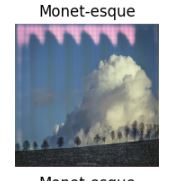

### Discussion and Conclusion

As mentioned in the results, my efforts to enhance the models actually ended up hurting the score of the notebook. The differences in the score were small so there may still be value in exploring the types of changes that I made.

Reviewing back through the changes that I made, many of the benefits of the changes can also be delivered with the UNET architecture that is used in the tutorial notebook. Because the base architecture may already be delivering those benefits, the changes ended up being detrimental. Despite the fact that my changes didn't improve the score, I was able to learn a lot about the potential changes to networks in this type of image generation context.

As I researched ways to improve this GAN, I noticed there are many different architectures based on U-NET. Below, I included a table from a study that compared the performances of various approaches. As a next step, I could have tried implementing these architectures rather than making changes at my own discretion.

Table source: https://www.nature.com/articles/s41598-022-18646-2

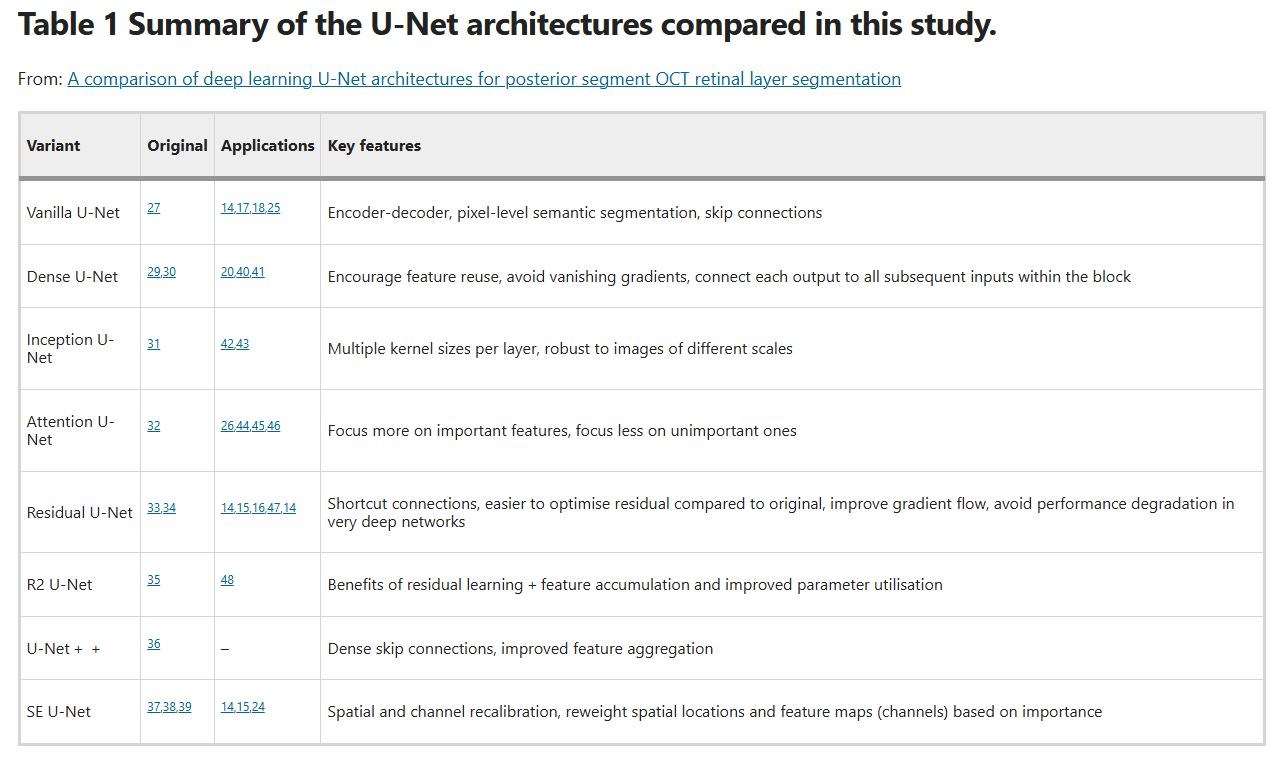